In [1]:
NOQUANT_TRAIN = False
n_epochs = 50
batches = 128
imsize = 32
print_freq = 50

In [2]:
import os
import shutil
import time
import pandas as pd
import matplotlib.pyplot as plt
import network.resnet_orig as resnet

from tqdm.notebook import tqdm
import time
import numpy as np
import pandas as pd
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler, RandomSampler, SequentialSampler
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau


In [3]:
# make dataset
import glob

datas = []

for cat in glob.glob("data/mini_speech_commands/*"):
    for file in glob.glob(os.path.join(cat, "*wav")):
        datas.append({"cat": cat.split("/")[-1], "filepath": file})
train_df= pd.DataFrame(datas)
train_df

,cat,filepath
0,right,data/mini_speech_commands/right/ced4e2a1_nohas...
1,right,data/mini_speech_commands/right/b6091c84_nohas...
2,right,data/mini_speech_commands/right/7ab5b8f7_nohas...
3,right,data/mini_speech_commands/right/3c257192_nohas...
4,right,data/mini_speech_commands/right/ffb86d3c_nohas...
...,...,...
7995,go,data/mini_speech_commands/go/7be5a0f3_nohash_0...
7996,go,data/mini_speech_commands/go/dc6e9c04_nohash_0...
7997,go,data/mini_speech_commands/go/df1d5024_nohash_0...
7998,go,data/mini_speech_commands/go/3c257192_nohash_2...


In [4]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_df['label_enc'] = le.fit_transform(train_df['cat'])

# 5-fold
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

train_df["fold"] = -1
for i, (train_index, test_index) in enumerate(skf.split(train_df.cat, train_df.label_enc)):
    train_df.loc[test_index, 'fold'] = i
train_df.head()

,cat,filepath,label_enc,fold
0,right,data/mini_speech_commands/right/ced4e2a1_nohas...,4,2
1,right,data/mini_speech_commands/right/b6091c84_nohas...,4,3
2,right,data/mini_speech_commands/right/7ab5b8f7_nohas...,4,3
3,right,data/mini_speech_commands/right/3c257192_nohas...,4,3
4,right,data/mini_speech_commands/right/ffb86d3c_nohas...,4,2


In [5]:
train_df.cat.unique()

array(['right', 'left', 'stop', 'no', 'yes', 'up', 'down', 'go'],
      dtype=object)

In [6]:
import torchaudio
import torch.nn.functional as F
import torchaudio.transforms as T

In [7]:
signal_1, sr = torchaudio.load(file)
sr

16000

In [8]:
n_fft=1024
hop_length=512
n_mels=64

In [9]:
mel_spectrogram = torchaudio.transforms.MelSpectrogram(sample_rate=sr, 
                                                      n_fft=n_fft, 
                                                      hop_length=hop_length, 
                                                      n_mels=n_mels)

torch.Size([1, 64, 32])

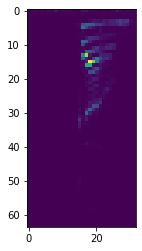

In [10]:
el_1 = mel_spectrogram(signal_1)
plt.imshow(el_1.detach().numpy()[0])

el_1.size()

In [11]:
import torchvision

class commandDataset(Dataset):
    def __init__(self,
                 df,
                 rand=False,
                 transform=None,
                 test=False
                ):

        self.df = df.reset_index(drop=True)
        self.rand = rand
        self.transform = transform
        self.test = test
        self.mel_spectrogram = torchaudio.transforms.MelSpectrogram(sample_rate=sr, 
                                                      n_fft=n_fft, 
                                                      hop_length=hop_length, 
                                                      n_mels=n_mels)
        self.num_samples = 32
        
        import albumentations
        self.transforms = torchvision.transforms.Resize(imsize)
        
    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        row = self.df.iloc[index]
        signal, sr = torchaudio.load(row.filepath)
        
        if sr != 16000:
            resampler = torchaudio.transforms.Resample(sr, 16000)
            signal = resampler(signal)
        
        signal = self.mel_spectrogram(signal)
        
        if signal.shape[1] > self.num_samples:
            signal = signal[:, :self.num_samples]
        # If it is less than the required number of samples, we pad the signal
        if signal.shape[1]<self.num_samples:
            num_missing_samples = self.num_samples - signal.shape[0]
            last_dim_padding = (0, num_missing_samples)
            signal = F.pad(signal, last_dim_padding)
            
        if signal.shape[2] > self.num_samples:
            signal = signal[:, :, :self.num_samples]
        # If it is less than the required number of samples, we pad the signal
        if signal.shape[2]<self.num_samples:
            num_missing_samples = self.num_samples - signal.shape[2]
            last_dim_padding = (0, num_missing_samples)
            signal = F.pad(signal, last_dim_padding)
        #print(np.shape(signal))
        
        # Load labels
        label = row.label_enc        
        label = label.astype(np.float32)

        return torch.tensor(signal/255), torch.tensor(label),

/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


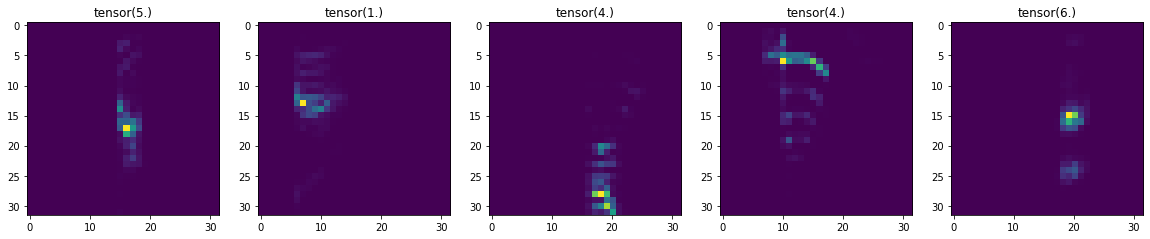

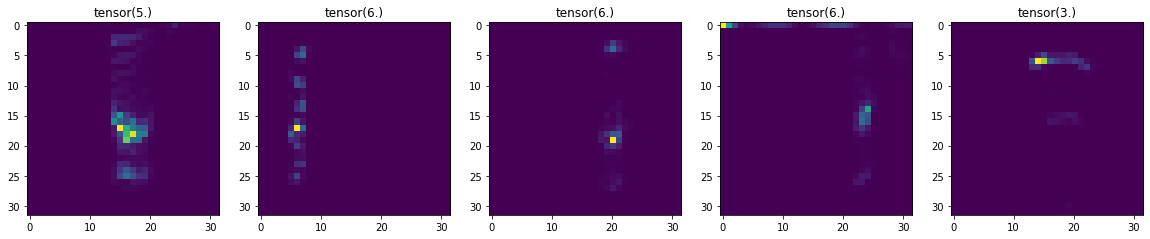

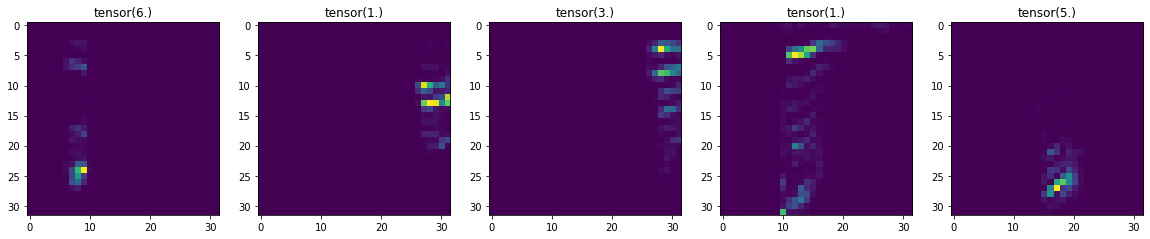

In [12]:
dataset_show = commandDataset(train_df)
from pylab import rcParams
rcParams['figure.figsize'] = 20,10
for i in range(3):
    f, axarr = plt.subplots(1,5)
    for p in range(5):
        idx = np.random.randint(0, len(dataset_show))
        img, label = dataset_show[idx]
        img = img.flip(0) #BGR2RGB
        axarr[p].imshow(img.transpose(0,1).transpose(1,2))
        axarr[p].set_title(str(label))
plt.show()

In [13]:
def train(train_loader, model, criterion, optimizer, epoch):
    """
        Run one train epoch
    """
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to train mode
    model.train()

    end = time.time()
    lambda_alpha = 0.002
    for i, (input, target) in enumerate(tqdm(train_loader)):

        # measure data loading time
        data_time.update(time.time() - end)
        target2 = target

        target = target.long().cuda()
        target2 = target2.long().cuda()
        input_var = input.cuda()
        target_var = target

        if not mixup:
          alpha = 0
        else:
          alpha = 1
        

        # compute output
        output = model(input_var)
        loss = criterion(output, target_var)

        # L2 regularization
        l2_alpha = 0.0
        for name, param in model.named_parameters():
            if "alpha" in name:
                l2_alpha += torch.pow(param, 2)
        loss += lambda_alpha * l2_alpha

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        output = output.float()
        loss = loss.float()
        # measure accuracy and record loss
        prec1 = accuracy(output.data, target)[0]
        losses.update(loss.item(), input.size(0))
        top1.update(prec1.item(), input.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                      epoch, i, len(train_loader), batch_time=batch_time,
                      data_time=data_time, loss=losses, top1=top1))
    return losses.avg

def validate(val_loader, model, criterion):
    """
    Run evaluation
    """
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to evaluate mode
    model.eval()

    end = time.time()
    with torch.no_grad():
        for i, (input, target) in enumerate(val_loader):
            target = target.long().cuda()
            input_var = input.cuda()
            target_var = target.cuda()

            # compute output
            output = model(input_var)
            loss = criterion(output, target_var)

            output = output.float()
            loss = loss.float()

            # measure accuracy and record loss
            prec1 = accuracy(output.data, target)[0]
            losses.update(loss.item(), input.size(0))
            top1.update(prec1.item(), input.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % print_freq == 0:
                print('Test: [{0}/{1}]\t'
                      'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                      'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                      'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                          i, len(val_loader), batch_time=batch_time, loss=losses,
                          top1=top1))

    print(' * Prec@1 {top1.avg:.3f}'
          .format(top1=top1))
    for name, param in model.named_parameters():
        if "alpha" in name:
            print(name, param.item())
    return top1.avg, losses.avg

def save_checkpoint(state, filename='checkpoint.pth'):
    """
    Save the training model
    """
    torch.save(state, filename)

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [14]:
train_dataset = commandDataset(train_df[train_df.fold!=0])
val_dataset = commandDataset(train_df[train_df.fold==0], test=True)

train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batches, shuffle=True,
        num_workers=8, pin_memory=True)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batches, shuffle=False,
    num_workers=8, pin_memory=True)

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from module import ActFn, Conv2d, Linear
from torch.autograd import Variable

__all__ = ['ResNet', 'resnet20', 'resnet34']

def _weights_init(m):
    classname = m.__class__.__name__
    #print(classname)
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight)

class LambdaLayer(nn.Module):
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, k=8, expansion=1):
        super(BasicBlock, self).__init__()
        self.k = k
        self.expansion = expansion
        # self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.conv1 = Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False, bitwidth = k)
        self.bn1 = nn.BatchNorm2d(planes)
        self.alpha1 = nn.Parameter(torch.tensor(10.))
        # self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.conv2 = Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False, bitwidth = k)
        self.bn2 = nn.BatchNorm2d(planes)
        self.alpha2 = nn.Parameter(torch.tensor(10.))
        self.ActFn = ActFn.apply
        
        if stride != 1 or in_planes != planes:
              # original resnet shortcut
              self.shortcut = nn.Sequential(
                    # nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                    Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                    nn.BatchNorm2d(self.expansion * planes)
              )
        else: # nothing done if stride or inplanes do not differ
          self.shortcut = nn.Sequential()

    def forward(self, x):
        # out = F.relu(self.bn1(self.conv1(x)))
        out = self.ActFn(self.bn1(self.conv1(x)), self.alpha1, self.k)
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        # out = F.relu(out)
        out = self.ActFn(out, self.alpha2, self.k)
        return out

    
class SimNet(nn.Module):
    def __init__(self, num_classes=8, K=16):
        super(SimNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1, bias=False,)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1, bias=False,)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=False,)
        self.bn4 = nn.BatchNorm2d(128)
        self.linear1 = nn.Linear(128, 128)
        self.linear2 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.25)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.avg_pool2d(x, x.size()[3])
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        #print(x.size())
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        return x

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=8, K=8):
        super(ResNet, self).__init__()
        self.in_planes = 16
        self.k = K

        # self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.conv1 = Conv2d(1, 16, kernel_size=3, stride=1, padding=1, bias=False, bitwidth = 8)
        self.bn1 = nn.BatchNorm2d(16)
        self.alpha1 = nn.Parameter(torch.tensor(10.))
        self.ActFn = ActFn.apply
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1, expansion=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2, expansion=1)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2, expansion=1)

        # self.linear = nn.Linear(64, num_classes)
        self.linear = Linear(64, num_classes, bitwidth = 8)
        self.apply(_weights_init)

    def _make_layer(self, block, planes, num_blocks, stride, expansion):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride, self.k, expansion))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        # out = F.relu(self.bn1(self.conv1(x)))
        out = self.ActFn(self.bn1(self.conv1(x)), self.alpha1, self.k)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def resnet20(k=8):
    print("bit width:", k)
    return ResNet(BasicBlock, [3, 3, 3], K=k)

In [16]:
net = SimNet()
net(torch.randn(1,1,32,32)).size()

torch.Size([1, 8])

In [17]:
net

SimNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear1): Linear(in_features=128, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=8, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [18]:
from timm.scheduler import CosineLRScheduler

for k in range(8,9):
    net = SimNet(K=k)

    model = net.cuda()
    mixup = False

    # Track experiment with wandb
    import wandb
    watermark = "simnet_bit{}".format(k)

    # mess with wandb
    wandb.init(project="voice_recog", name=watermark)

    # define loss function (criterion) and pptimizer
    criterion = nn.CrossEntropyLoss().cuda()

    # optimizer for pact
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-3,
                                momentum=0.9,
                                weight_decay=0.0002)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

    scheduler = CosineLRScheduler(optimizer, t_initial=n_epochs, lr_min=1e-4, 
                          warmup_t=3, warmup_lr_init=1e-4, warmup_prefix=True)

    best_prec1 = 0
    os.makedirs("models", exist_ok=True)

    for epoch in range(n_epochs):
        scheduler.step(epoch)
        # train for one epoch
        print('current lr {:.5e}'.format(optimizer.param_groups[0]['lr']))
        tloss = train(train_loader, model, criterion, optimizer, epoch)         

        # evaluate on validation set
        prec1, valloss = validate(val_loader, model, criterion)

        # wandb
        wandb.log({'epoch': epoch, "prec":prec1, "train_loss": tloss, 'val_loss': valloss, "lr": optimizer.param_groups[0]["lr"],})

        # remember best prec@1 and save checkpoint
        is_best = prec1 > best_prec1
        best_prec1 = max(prec1, best_prec1)

        print("Best prec1 : ", best_prec1)
        if is_best:
            torch.save(model.state_dict(), os.path.join(f'models/{watermark}.pth'))

wandb: Currently logged in as: arutema47. Use `wandb login --relogin` to force relogin


current lr 1.00000e-04


  0%|          | 0/50 [00:00<?, ?it/s]

/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it

Epoch: [0][0/50]	Time 0.866 (0.866)	Data 0.390 (0.390)	Loss 2.0788 (2.0788)	Prec@1 13.281 (13.281)


/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it

Test: [0/13]	Time 0.397 (0.397)	Loss 2.0822 (2.0822)	Prec@1 0.000 (0.000)
 * Prec@1 13.375
Best prec1 :  13.375
current lr 3.40000e-03


  0%|          | 0/50 [00:00<?, ?it/s]

/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it

Epoch: [1][0/50]	Time 0.396 (0.396)	Data 0.383 (0.383)	Loss 2.0692 (2.0692)	Prec@1 18.750 (18.750)


/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it

Test: [0/13]	Time 0.365 (0.365)	Loss 3.2510 (3.2510)	Prec@1 0.000 (0.000)
 * Prec@1 12.625
Best prec1 :  13.375
current lr 6.70000e-03


  0%|          | 0/50 [00:00<?, ?it/s]

/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it

Epoch: [2][0/50]	Time 0.416 (0.416)	Data 0.403 (0.403)	Loss 1.9802 (1.9802)	Prec@1 18.750 (18.750)


/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it

Test: [0/13]	Time 0.359 (0.359)	Loss 1.9545 (1.9545)	Prec@1 26.562 (26.562)
 * Prec@1 22.250
Best prec1 :  22.25
current lr 1.00000e-02


  0%|          | 0/50 [00:00<?, ?it/s]

/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it

Epoch: [3][0/50]	Time 0.385 (0.385)	Data 0.372 (0.372)	Loss 1.9026 (1.9026)	Prec@1 21.094 (21.094)


/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it

Test: [0/13]	Time 0.367 (0.367)	Loss 1.7764 (1.7764)	Prec@1 41.406 (41.406)
 * Prec@1 28.188
Best prec1 :  28.1875
current lr 9.99023e-03


  0%|          | 0/50 [00:00<?, ?it/s]

/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it

Epoch: [4][0/50]	Time 0.407 (0.407)	Data 0.395 (0.395)	Loss 1.7716 (1.7716)	Prec@1 35.156 (35.156)


/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it

Test: [0/13]	Time 0.388 (0.388)	Loss 12.3896 (12.3896)	Prec@1 0.000 (0.000)
 * Prec@1 12.500
Best prec1 :  28.1875
current lr 9.96097e-03


  0%|          | 0/50 [00:00<?, ?it/s]

/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it

Epoch: [5][0/50]	Time 0.425 (0.425)	Data 0.412 (0.412)	Loss 1.6647 (1.6647)	Prec@1 35.938 (35.938)


/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it

Test: [0/13]	Time 0.367 (0.367)	Loss 2.5114 (2.5114)	Prec@1 17.969 (17.969)
 * Prec@1 22.562
Best prec1 :  28.1875
current lr 9.91232e-03


  0%|          | 0/50 [00:00<?, ?it/s]

/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it

Epoch: [6][0/50]	Time 0.388 (0.388)	Data 0.375 (0.375)	Loss 1.6652 (1.6652)	Prec@1 32.812 (32.812)


/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it

Test: [0/13]	Time 0.378 (0.378)	Loss 6.6404 (6.6404)	Prec@1 0.000 (0.000)
 * Prec@1 15.438
Best prec1 :  28.1875
current lr 9.84449e-03


  0%|          | 0/50 [00:00<?, ?it/s]

/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it

Epoch: [7][0/50]	Time 0.423 (0.423)	Data 0.410 (0.410)	Loss 1.5053 (1.5053)	Prec@1 37.500 (37.500)


/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it

Test: [0/13]	Time 0.400 (0.400)	Loss 3.9476 (3.9476)	Prec@1 2.344 (2.344)
 * Prec@1 18.562
Best prec1 :  28.1875
current lr 9.75773e-03


  0%|          | 0/50 [00:00<?, ?it/s]

/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it

Epoch: [8][0/50]	Time 0.424 (0.424)	Data 0.411 (0.411)	Loss 1.4363 (1.4363)	Prec@1 50.781 (50.781)


/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it

Test: [0/13]	Time 0.390 (0.390)	Loss 1.5570 (1.5570)	Prec@1 36.719 (36.719)
 * Prec@1 41.438
Best prec1 :  41.4375
current lr 9.65239e-03


  0%|          | 0/50 [00:00<?, ?it/s]

/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it

Epoch: [9][0/50]	Time 0.389 (0.389)	Data 0.377 (0.377)	Loss 1.3448 (1.3448)	Prec@1 52.344 (52.344)


/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it

Test: [0/13]	Time 0.363 (0.363)	Loss 0.0419 (0.0419)	Prec@1 100.000 (100.000)
 * Prec@1 14.875
Best prec1 :  41.4375
current lr 9.52889e-03


  0%|          | 0/50 [00:00<?, ?it/s]

/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it

Epoch: [10][0/50]	Time 0.395 (0.395)	Data 0.383 (0.383)	Loss 1.0664 (1.0664)	Prec@1 50.000 (50.000)


/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it

Test: [0/13]	Time 0.385 (0.385)	Loss 20.5408 (20.5408)	Prec@1 0.000 (0.000)
 * Prec@1 12.688
Best prec1 :  41.4375
current lr 9.38772e-03


  0%|          | 0/50 [00:00<?, ?it/s]

/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it

Epoch: [11][0/50]	Time 0.383 (0.383)	Data 0.370 (0.370)	Loss 1.1751 (1.1751)	Prec@1 56.250 (56.250)


/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it

Test: [0/13]	Time 0.359 (0.359)	Loss 11.1241 (11.1241)	Prec@1 0.000 (0.000)
 * Prec@1 13.688
Best prec1 :  41.4375
current lr 9.22942e-03


  0%|          | 0/50 [00:00<?, ?it/s]

/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it

Epoch: [12][0/50]	Time 0.409 (0.409)	Data 0.397 (0.397)	Loss 1.1489 (1.1489)	Prec@1 57.812 (57.812)


/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it

Test: [0/13]	Time 0.391 (0.391)	Loss 1.0343 (1.0343)	Prec@1 58.594 (58.594)
 * Prec@1 59.812
Best prec1 :  59.8125
current lr 9.05463e-03


  0%|          | 0/50 [00:00<?, ?it/s]

/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it

Epoch: [13][0/50]	Time 0.398 (0.398)	Data 0.386 (0.386)	Loss 0.8976 (0.8976)	Prec@1 70.312 (70.312)


/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it

Test: [0/13]	Time 0.396 (0.396)	Loss 1.5765 (1.5765)	Prec@1 40.625 (40.625)
 * Prec@1 51.812
Best prec1 :  59.8125
current lr 8.86404e-03


  0%|          | 0/50 [00:00<?, ?it/s]

/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it

Epoch: [14][0/50]	Time 0.382 (0.382)	Data 0.369 (0.369)	Loss 0.9438 (0.9438)	Prec@1 67.969 (67.969)


/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it

Test: [0/13]	Time 0.361 (0.361)	Loss 3.6577 (3.6577)	Prec@1 13.281 (13.281)
 * Prec@1 35.750
Best prec1 :  59.8125
current lr 8.65839e-03


  0%|          | 0/50 [00:00<?, ?it/s]

/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it

Epoch: [15][0/50]	Time 0.392 (0.392)	Data 0.380 (0.380)	Loss 0.9172 (0.9172)	Prec@1 63.281 (63.281)


/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it

Test: [0/13]	Time 0.376 (0.376)	Loss 1.1805 (1.1805)	Prec@1 50.781 (50.781)
 * Prec@1 54.000
Best prec1 :  59.8125
current lr 8.43851e-03


  0%|          | 0/50 [00:00<?, ?it/s]

/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it

Epoch: [16][0/50]	Time 0.402 (0.402)	Data 0.390 (0.390)	Loss 0.6895 (0.6895)	Prec@1 74.219 (74.219)


/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it

Test: [0/13]	Time 0.376 (0.376)	Loss 0.9543 (0.9543)	Prec@1 65.625 (65.625)
 * Prec@1 59.750
Best prec1 :  59.8125
current lr 8.20525e-03


  0%|          | 0/50 [00:00<?, ?it/s]

/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it

Epoch: [17][0/50]	Time 0.428 (0.428)	Data 0.415 (0.415)	Loss 0.8412 (0.8412)	Prec@1 67.969 (67.969)


/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it

Test: [0/13]	Time 0.357 (0.357)	Loss 21.3557 (21.3557)	Prec@1 1.562 (1.562)
 * Prec@1 19.438
Best prec1 :  59.8125
current lr 7.95954e-03


  0%|          | 0/50 [00:00<?, ?it/s]

/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it

Epoch: [18][0/50]	Time 0.398 (0.398)	Data 0.385 (0.385)	Loss 0.7603 (0.7603)	Prec@1 74.219 (74.219)


/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it

Test: [0/13]	Time 0.359 (0.359)	Loss 1.0686 (1.0686)	Prec@1 71.875 (71.875)
 * Prec@1 57.250
Best prec1 :  59.8125
current lr 7.70234e-03


  0%|          | 0/50 [00:00<?, ?it/s]

/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it

Epoch: [19][0/50]	Time 0.384 (0.384)	Data 0.372 (0.372)	Loss 0.8057 (0.8057)	Prec@1 67.969 (67.969)


/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it

Test: [0/13]	Time 0.385 (0.385)	Loss 1.4547 (1.4547)	Prec@1 52.344 (52.344)
 * Prec@1 54.625
Best prec1 :  59.8125
current lr 7.43468e-03


  0%|          | 0/50 [00:00<?, ?it/s]

/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it

Epoch: [20][0/50]	Time 0.383 (0.383)	Data 0.371 (0.371)	Loss 0.6597 (0.6597)	Prec@1 76.562 (76.562)


/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it

Test: [0/13]	Time 0.370 (0.370)	Loss 2.0771 (2.0771)	Prec@1 36.719 (36.719)
 * Prec@1 50.125
Best prec1 :  59.8125
current lr 7.15761e-03


  0%|          | 0/50 [00:00<?, ?it/s]

/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it

Epoch: [21][0/50]	Time 0.399 (0.399)	Data 0.387 (0.387)	Loss 0.6772 (0.6772)	Prec@1 73.438 (73.438)


/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it

Test: [0/13]	Time 0.369 (0.369)	Loss 0.8398 (0.8398)	Prec@1 67.969 (67.969)
 * Prec@1 66.875
Best prec1 :  66.875
current lr 6.87222e-03


  0%|          | 0/50 [00:00<?, ?it/s]

/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it

Epoch: [22][0/50]	Time 0.384 (0.384)	Data 0.370 (0.370)	Loss 0.5873 (0.5873)	Prec@1 82.812 (82.812)


/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it

Test: [0/13]	Time 0.393 (0.393)	Loss 1.7004 (1.7004)	Prec@1 45.312 (45.312)
 * Prec@1 46.500
Best prec1 :  66.875
current lr 6.57963e-03


  0%|          | 0/50 [00:00<?, ?it/s]

/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it

Epoch: [23][0/50]	Time 0.399 (0.399)	Data 0.387 (0.387)	Loss 0.5841 (0.5841)	Prec@1 78.906 (78.906)


/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it

Test: [0/13]	Time 0.359 (0.359)	Loss 0.9470 (0.9470)	Prec@1 62.500 (62.500)
 * Prec@1 61.188
Best prec1 :  66.875
current lr 6.28101e-03


  0%|          | 0/50 [00:00<?, ?it/s]

/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it

Epoch: [24][0/50]	Time 0.390 (0.390)	Data 0.378 (0.378)	Loss 0.5057 (0.5057)	Prec@1 80.469 (80.469)


/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it

Test: [0/13]	Time 0.365 (0.365)	Loss 9.1387 (9.1387)	Prec@1 7.031 (7.031)
 * Prec@1 28.125
Best prec1 :  66.875
current lr 5.97754e-03


  0%|          | 0/50 [00:00<?, ?it/s]

/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it

Epoch: [25][0/50]	Time 0.412 (0.412)	Data 0.399 (0.399)	Loss 0.6833 (0.6833)	Prec@1 75.781 (75.781)


/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it

Test: [0/13]	Time 0.377 (0.377)	Loss 2.7596 (2.7596)	Prec@1 29.688 (29.688)
 * Prec@1 52.000
Best prec1 :  66.875
current lr 5.67040e-03


  0%|          | 0/50 [00:00<?, ?it/s]

/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it

Epoch: [26][0/50]	Time 0.394 (0.394)	Data 0.381 (0.381)	Loss 0.5280 (0.5280)	Prec@1 82.812 (82.812)


/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it

Test: [0/13]	Time 0.394 (0.394)	Loss 0.6995 (0.6995)	Prec@1 73.438 (73.438)
 * Prec@1 63.938
Best prec1 :  66.875
current lr 5.36081e-03


  0%|          | 0/50 [00:00<?, ?it/s]

/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it

Epoch: [27][0/50]	Time 0.402 (0.402)	Data 0.389 (0.389)	Loss 0.4676 (0.4676)	Prec@1 85.938 (85.938)


/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it

Test: [0/13]	Time 0.377 (0.377)	Loss 20.9965 (20.9965)	Prec@1 3.906 (3.906)
 * Prec@1 20.875
Best prec1 :  66.875
current lr 5.05000e-03


  0%|          | 0/50 [00:00<?, ?it/s]

/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it

Epoch: [28][0/50]	Time 0.411 (0.411)	Data 0.399 (0.399)	Loss 0.4593 (0.4593)	Prec@1 88.281 (88.281)


/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it

Test: [0/13]	Time 0.394 (0.394)	Loss 13.4710 (13.4710)	Prec@1 11.719 (11.719)
 * Prec@1 23.188
Best prec1 :  66.875
current lr 4.73919e-03


  0%|          | 0/50 [00:00<?, ?it/s]

/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it

Epoch: [29][0/50]	Time 0.407 (0.407)	Data 0.394 (0.394)	Loss 0.5033 (0.5033)	Prec@1 83.594 (83.594)


/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it

Test: [0/13]	Time 0.366 (0.366)	Loss 3.4305 (3.4305)	Prec@1 24.219 (24.219)
 * Prec@1 44.750
Best prec1 :  66.875
current lr 4.42960e-03


  0%|          | 0/50 [00:00<?, ?it/s]

/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it

Epoch: [30][0/50]	Time 0.408 (0.408)	Data 0.395 (0.395)	Loss 0.5004 (0.5004)	Prec@1 84.375 (84.375)


/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it

Test: [0/13]	Time 0.368 (0.368)	Loss 3.2563 (3.2563)	Prec@1 36.719 (36.719)
 * Prec@1 37.375
Best prec1 :  66.875
current lr 4.12246e-03


  0%|          | 0/50 [00:00<?, ?it/s]

/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it

Epoch: [31][0/50]	Time 0.413 (0.413)	Data 0.401 (0.401)	Loss 0.2824 (0.2824)	Prec@1 90.625 (90.625)


/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it

Test: [0/13]	Time 0.375 (0.375)	Loss 1.3236 (1.3236)	Prec@1 51.562 (51.562)
 * Prec@1 54.750
Best prec1 :  66.875
current lr 3.81899e-03


  0%|          | 0/50 [00:00<?, ?it/s]

/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it

Epoch: [32][0/50]	Time 0.405 (0.405)	Data 0.393 (0.393)	Loss 0.4302 (0.4302)	Prec@1 83.594 (83.594)


/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it

Test: [0/13]	Time 0.365 (0.365)	Loss 0.5897 (0.5897)	Prec@1 79.688 (79.688)
 * Prec@1 72.500
Best prec1 :  72.5
current lr 3.52037e-03


  0%|          | 0/50 [00:00<?, ?it/s]

/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it

Epoch: [33][0/50]	Time 0.417 (0.417)	Data 0.405 (0.405)	Loss 0.4600 (0.4600)	Prec@1 83.594 (83.594)


/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it

Test: [0/13]	Time 0.391 (0.391)	Loss 7.0672 (7.0672)	Prec@1 28.125 (28.125)
 * Prec@1 41.500
Best prec1 :  72.5
current lr 3.22778e-03


  0%|          | 0/50 [00:00<?, ?it/s]

/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it

Epoch: [34][0/50]	Time 0.415 (0.415)	Data 0.402 (0.402)	Loss 0.5794 (0.5794)	Prec@1 78.125 (78.125)


/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it

Test: [0/13]	Time 0.371 (0.371)	Loss 2.6799 (2.6799)	Prec@1 33.594 (33.594)
 * Prec@1 47.188
Best prec1 :  72.5
current lr 2.94239e-03


  0%|          | 0/50 [00:00<?, ?it/s]

/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it

Epoch: [35][0/50]	Time 0.385 (0.385)	Data 0.372 (0.372)	Loss 0.3244 (0.3244)	Prec@1 90.625 (90.625)


/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it

Test: [0/13]	Time 0.370 (0.370)	Loss 7.1320 (7.1320)	Prec@1 19.531 (19.531)
 * Prec@1 35.312
Best prec1 :  72.5
current lr 2.66532e-03


  0%|          | 0/50 [00:00<?, ?it/s]

/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it

Epoch: [36][0/50]	Time 0.416 (0.416)	Data 0.404 (0.404)	Loss 0.2949 (0.2949)	Prec@1 88.281 (88.281)


/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it

Test: [0/13]	Time 0.353 (0.353)	Loss 1.4854 (1.4854)	Prec@1 49.219 (49.219)
 * Prec@1 53.312
Best prec1 :  72.5
current lr 2.39766e-03


  0%|          | 0/50 [00:00<?, ?it/s]

/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it

Epoch: [37][0/50]	Time 0.381 (0.381)	Data 0.368 (0.368)	Loss 0.3740 (0.3740)	Prec@1 88.281 (88.281)


/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it

Test: [0/13]	Time 0.391 (0.391)	Loss 0.9283 (0.9283)	Prec@1 61.719 (61.719)
 * Prec@1 61.438
Best prec1 :  72.5
current lr 2.14046e-03


  0%|          | 0/50 [00:00<?, ?it/s]

/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it

Epoch: [38][0/50]	Time 0.402 (0.402)	Data 0.390 (0.390)	Loss 0.4261 (0.4261)	Prec@1 84.375 (84.375)


/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it

Test: [0/13]	Time 0.398 (0.398)	Loss 2.4396 (2.4396)	Prec@1 42.969 (42.969)
 * Prec@1 50.250
Best prec1 :  72.5
current lr 1.89475e-03


  0%|          | 0/50 [00:00<?, ?it/s]

/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it

Epoch: [39][0/50]	Time 0.413 (0.413)	Data 0.401 (0.401)	Loss 0.4068 (0.4068)	Prec@1 85.938 (85.938)


/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it

Test: [0/13]	Time 0.368 (0.368)	Loss 0.8148 (0.8148)	Prec@1 67.969 (67.969)
 * Prec@1 49.125
Best prec1 :  72.5
current lr 1.66149e-03


  0%|          | 0/50 [00:00<?, ?it/s]

/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it

Epoch: [40][0/50]	Time 0.395 (0.395)	Data 0.382 (0.382)	Loss 0.3350 (0.3350)	Prec@1 89.844 (89.844)


/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it

Test: [0/13]	Time 0.364 (0.364)	Loss 0.8726 (0.8726)	Prec@1 64.844 (64.844)
 * Prec@1 63.938
Best prec1 :  72.5
current lr 1.44161e-03


  0%|          | 0/50 [00:00<?, ?it/s]

/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it

Epoch: [41][0/50]	Time 0.431 (0.431)	Data 0.419 (0.419)	Loss 0.3797 (0.3797)	Prec@1 87.500 (87.500)


/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it

Test: [0/13]	Time 0.390 (0.390)	Loss 1.0662 (1.0662)	Prec@1 60.156 (60.156)
 * Prec@1 61.562
Best prec1 :  72.5
current lr 1.23596e-03


  0%|          | 0/50 [00:00<?, ?it/s]

/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it

Epoch: [42][0/50]	Time 0.389 (0.389)	Data 0.377 (0.377)	Loss 0.2537 (0.2537)	Prec@1 92.188 (92.188)


/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it

Test: [0/13]	Time 0.389 (0.389)	Loss 1.6346 (1.6346)	Prec@1 40.625 (40.625)
 * Prec@1 51.375
Best prec1 :  72.5
current lr 1.04537e-03


  0%|          | 0/50 [00:00<?, ?it/s]

/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it

Epoch: [43][0/50]	Time 0.396 (0.396)	Data 0.383 (0.383)	Loss 0.3432 (0.3432)	Prec@1 88.281 (88.281)


/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it

Test: [0/13]	Time 0.369 (0.369)	Loss 0.9792 (0.9792)	Prec@1 60.938 (60.938)
 * Prec@1 63.688
Best prec1 :  72.5
current lr 8.70577e-04


  0%|          | 0/50 [00:00<?, ?it/s]

/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it

Epoch: [44][0/50]	Time 0.423 (0.423)	Data 0.411 (0.411)	Loss 0.2620 (0.2620)	Prec@1 92.188 (92.188)


/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it

Test: [0/13]	Time 0.353 (0.353)	Loss 1.0101 (1.0101)	Prec@1 60.938 (60.938)
 * Prec@1 65.875
Best prec1 :  72.5
current lr 7.12282e-04


  0%|          | 0/50 [00:00<?, ?it/s]

/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it

Epoch: [45][0/50]	Time 0.402 (0.402)	Data 0.390 (0.390)	Loss 0.3325 (0.3325)	Prec@1 86.719 (86.719)


/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it

Test: [0/13]	Time 0.367 (0.367)	Loss 2.0972 (2.0972)	Prec@1 42.188 (42.188)
 * Prec@1 51.750
Best prec1 :  72.5
current lr 5.71106e-04


  0%|          | 0/50 [00:00<?, ?it/s]

/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it

Epoch: [46][0/50]	Time 0.410 (0.410)	Data 0.397 (0.397)	Loss 0.3190 (0.3190)	Prec@1 87.500 (87.500)


/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it

Test: [0/13]	Time 0.362 (0.362)	Loss 1.5398 (1.5398)	Prec@1 45.312 (45.312)
 * Prec@1 51.625
Best prec1 :  72.5
current lr 4.47606e-04


  0%|          | 0/50 [00:00<?, ?it/s]

/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it

Epoch: [47][0/50]	Time 0.398 (0.398)	Data 0.386 (0.386)	Loss 0.2498 (0.2498)	Prec@1 89.844 (89.844)


/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it

Test: [0/13]	Time 0.366 (0.366)	Loss 1.0636 (1.0636)	Prec@1 57.812 (57.812)
 * Prec@1 60.312
Best prec1 :  72.5
current lr 3.42270e-04


  0%|          | 0/50 [00:00<?, ?it/s]

/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it

Epoch: [48][0/50]	Time 0.399 (0.399)	Data 0.386 (0.386)	Loss 0.2266 (0.2266)	Prec@1 93.750 (93.750)


/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it

Test: [0/13]	Time 0.400 (0.400)	Loss 1.2983 (1.2983)	Prec@1 56.250 (56.250)
 * Prec@1 61.688
Best prec1 :  72.5
current lr 2.55513e-04


  0%|          | 0/50 [00:00<?, ?it/s]

/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it

Epoch: [49][0/50]	Time 0.405 (0.405)	Data 0.393 (0.393)	Loss 0.1856 (0.1856)	Prec@1 92.969 (92.969)


/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it

Test: [0/13]	Time 0.383 (0.383)	Loss 1.1683 (1.1683)	Prec@1 52.344 (52.344)
 * Prec@1 52.250
Best prec1 :  72.5
